# Cats vs Dogs transfer learning


### Llibreries necessaries

Veurem que a més de les llibreries habituals també importem la llibreria `tensorflow_datasets` que conté el nostre conjunt de dades.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
# Altres llibreries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


## Cárrega de dades

Carregam les dades, a l'hora que les baixam també definim els conjunts de validació i test. 

En segon lloc redimensionam les imatges i cream _batch_ de mida 32, es a dir que contenen 32 imatges.

In [2]:
# Descarregam el conjunt de dades ja divit
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Incluim les etiquetes
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7GW0AB/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
img_size = (128, 128) # Definim la mida de les nostres imatges, les reescalam totes a aquesta mida
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
# Cream els batchs
train_ds = train_ds.cache().batch(32).prefetch(buffer_size=10)
# Conjunt de validació
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.cache().batch(1).prefetch(buffer_size=10)

Mostram alguns exemples del conjunt d'entrenament, és important saber com son les dades que emprarem i com a mínim hem de fer una petita exploració:

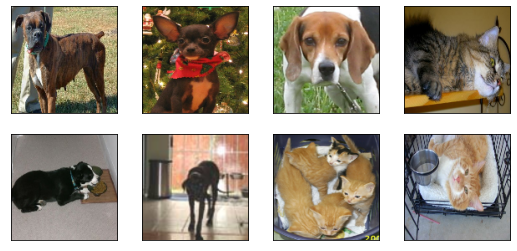

In [4]:
it = train_ds.as_numpy_iterator() # Cream un iterador sobre el conjunt d'entrenament
img_batch = next(it)

n_images = 8
figure = plt.figure(figsize=(9, 9))
for i in range(n_images):

  ax = plt.subplot(n_images/2, n_images//2, i + 1)
  ax.set_xticks(())
  ax.set_yticks(())
  ax.imshow(img_batch[0][i,:,:]/255)

## Definició del model

En aquest cas no dissenyarem un model propi, sino que n'emprarem un que ja és molt usat en tasques de classificació: ResNet50:

ResNet-50 és una xarxa neuronal convolucional de **50 capes de profunditat**. Carregarem una versió prèviament entrenada de la xarxa en més d'un milió d'imatges de la base de dades ImageNet(veure referència). La xarxa prèviament entrenada pot classificar imatges de 1000 categories d'objectes, com ara: teclat, ratolí, llapis i diversos animals.

- Imagenet [enllaç](https://image-net.org/)
- Documentació ResNet-50: [enllaç](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

In [5]:
IMG_SHAPE = img_size + (3,)

base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, # Obtenim l'extractor de característiques, no el classificador
                                                     weights='imagenet', # Sobre quina base de dades s'ha entrenat.
                                                     input_shape=IMG_SHAPE)



94781440/94765736 [==============================] - 1s 0us/step


In [6]:
#model.summary() # No mostram el model, és molt llarg.

## Compilar i entrenar el model 

Utilitzant la API funcional de Keras afegim un classificador al model previament importat. Aquest classificador consta d'una capa `Flatten` i una
capa densa (`Dense`).

In [7]:
base_model.trainable = False # No tornam a entrenar.

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model(base_model.inputs, outputs)


In [8]:
#model.summary()

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [10]:
initial_epochs = 1

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)


291/291 [==============================] - 86s 250ms/step - loss: 0.6843 - accuracy: 0.9095 - val_loss: 0.6138 - val_accuracy: 0.9428


## Proves finals

Classifiquem diverses imatges del conjunt de test. Aquest codi és una mica diferent al que usam per visualitzar el conjunt d'entrenament per dos motius:

- En el conjunt de test el batch és 1, per tant la manera d'accedir a les imatges canvia una mica.

- Hem de realitzar la predicció.

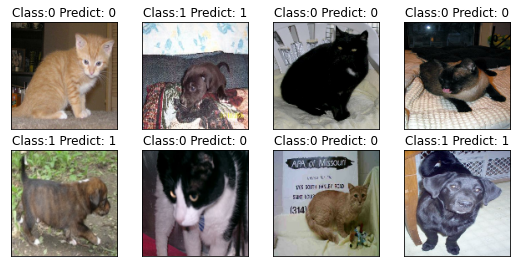

In [14]:
it_test = validation_ds.as_numpy_iterator()


n_images = 8
figure = plt.figure(figsize=(9, 9))

for i in range(n_images):

  img_batch = next(it_test)
  ax = plt.subplot(n_images/2, n_images//2, i + 1)
  ax.imshow(img_batch[0][0,:,:,:]/255)
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title( "Class:" +  str(img_batch[1][0]) + " Predict: " + str(int(model.predict(img_batch[0]))))
